# A/B Testing Scenario: **Interactive Cares** Website Layout Engagement Time

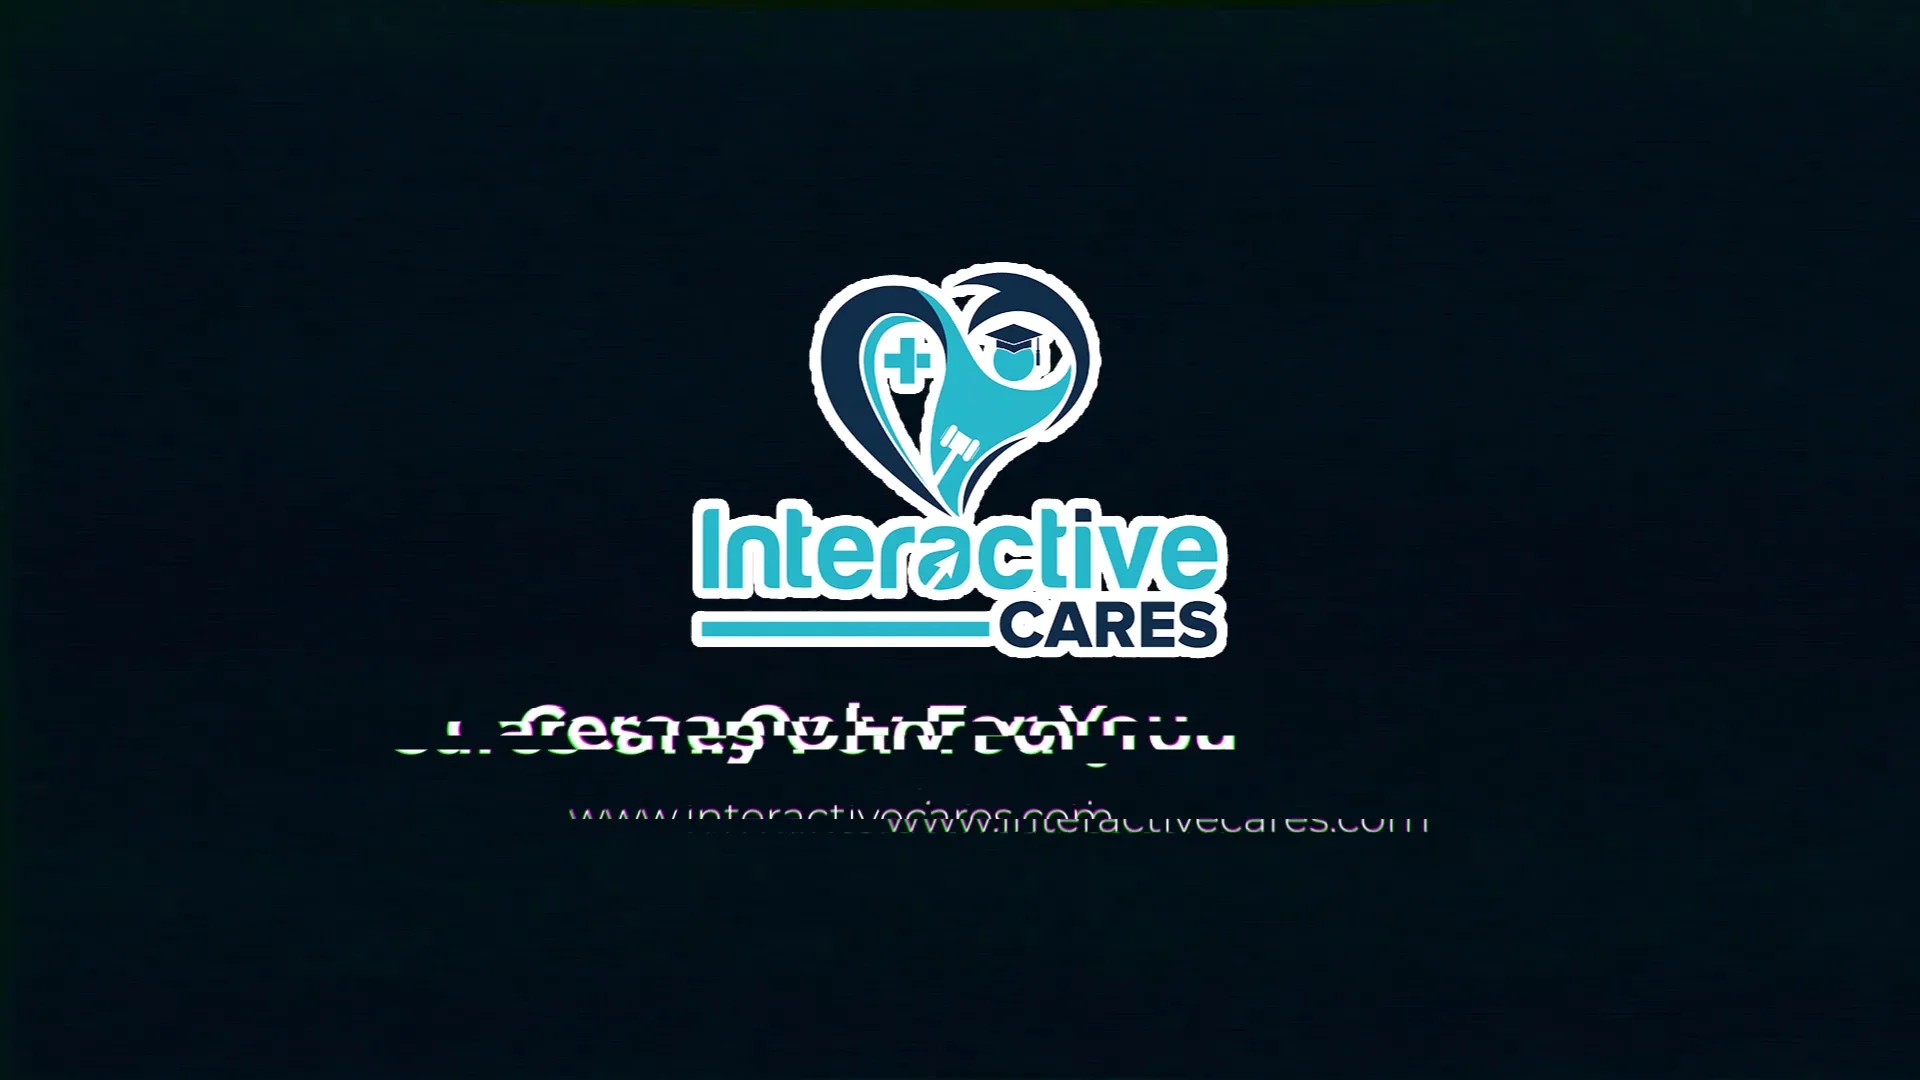

# This notebook demonstrates an A/B test comparing user engagement time on two different website layouts (Old vs New)

## **1. Importing the Necessary Libraries**

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.power as smp

In [6]:
# Set plot style
sns.set(style="whitegrid")

## **2. Defining Business Scenario & Goal**
**Scenario:** A Bangladeshi Skill Learning Platform **Interactive Cares** wants to test if a newly designed user dashboard (Version B) leads to higher average user engagement time (measured in minutes per session) compared to the current dashboard (Version A).

**Goal:** Determine if the difference in average engagement time is statistically significant.

 **Metric:** Average Session Duration (in minutes).

## **3. Defining Hypothesis**

We want to see if the new version (B) *increases* engagement time compared to the old version (A).
This suggests a one-tailed test, but it's often safer and more common to start with a two-tailed test unless there's a very strong reason otherwise (e.g., we absolutely don't care if B is worse).

Let's formulate both:

**Null Hypothesis (H₀):** 
There is no difference in the mean engagement time between Version A and Version B.
Mathematically: μ_A = μ_B  (or μ_B - μ_A = 0)

**Alternative Hypothesis (H₁):** 
There is a difference in the mean engagement time between Version A and Version B.
Mathematically (Two-tailed): μ_A ≠ μ_B (or μ_B - μ_A ≠ 0)
Mathematically (One-tailed, if we only care if B is better): μ_B > μ_A (or μ_B - μ_A > 0)

**Significance Level (α):** 
We'll set the standard significance level at 0.05.

In [8]:
alpha = 0.05

## **4. Data Generation (Synthetic)**

**In a real world scenario, this data would come from tracking user sessions. Here, we'll generate synthetic data simulating the results. Let's assume we ran the test and collected data for 500 users in each group.**

In [9]:
np.random.seed(42) # for reproducibility

In [11]:
# Group A (Old Layout) - Assume mean engagement of 15 minutes, std dev of 5
sample_size_A = 500
mean_A = 15.0
std_dev_A = 5.0
engagement_A = np.random.normal(loc=mean_A, scale=std_dev_A, size=sample_size_A)

# Ensure no negative times (practical consideration)
engagement_A[engagement_A < 0] = 0

In [13]:
# Group B (New Layout) - Assume a slightly higher mean engagement of 16.5 minutes, std dev of 5.5
sample_size_B = 500
mean_B = 16.5 # Let's hypothesize the new design is slightly better
std_dev_B = 5.5
engagement_B = np.random.normal(loc=mean_B, scale=std_dev_B, size=sample_size_B)

# Ensure no negative times
engagement_B[engagement_B < 0] = 0

In [14]:
# Create a DataFrame for easier handling
df_A = pd.DataFrame({'Group': 'A', 'EngagementTime': engagement_A})
df_B = pd.DataFrame({'Group': 'B', 'EngagementTime': engagement_B})
df = pd.concat([df_A, df_B], ignore_index=True)

In [18]:
print("Dataset Overview:")
df.head()

Dataset Overview:


,Group,EngagementTime
0,A,17.483571
1,A,14.308678
2,A,18.238443
3,A,22.615149
4,A,13.829233


In [19]:
print("Dataset Overview:")
df.tail()

Dataset Overview:


,Group,EngagementTime
995,B,27.533511
996,B,27.838270
997,B,23.146014
998,B,22.132344
999,B,19.758898


In [20]:
print("\nSummary Statistics per Group:")
df.groupby('Group')['EngagementTime'].describe()


Summary Statistics per Group:


,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
A,500.0,15.036603,4.898554,0.000000,11.498463,15.063986,18.183916,34.263657
B,500.0,17.096665,5.556355,0.570595,13.186637,17.158932,20.651061,30.809257


## **5. Assumption Checks for Independent Samples t-test**

The Independent Samples t-test has two main assumptions:
Independence of Observations (assumed by design in A/B testing - users are randomly assigned).
1. Normality of Data: The data in each group should be approximately normally distributed.
2. Homogeneity of Variances (Homoscedasticity): The variances of the two groups should be equal.

### **5.1. Normality Check (Shapiro-Wilk Test)**

In [22]:
# H₀: The data is normally distributed.
# H₁: The data is not normally distributed.

print("\n--- Normality Check (Shapiro-Wilk Test) ---")
shapiro_A = stats.shapiro(df[df['Group'] == 'A']['EngagementTime'])
shapiro_B = stats.shapiro(df[df['Group'] == 'B']['EngagementTime'])

print(f"Group A: Statistics={shapiro_A.statistic:.4f}, p-value={shapiro_A.pvalue:.4f}")
print(f"Group B: Statistics={shapiro_B.statistic:.4f}, p-value={shapiro_B.pvalue:.4f}")


--- Normality Check (Shapiro-Wilk Test) ---
Group A: Statistics=0.9966, p-value=0.3853
Group B: Statistics=0.9973, p-value=0.5760


In [23]:
# Interpretation of Normality Test
if shapiro_A.pvalue > alpha and shapiro_B.pvalue > alpha:
    print("Interpretation: Both groups appear normally distributed (fail to reject H₀).")
    normality_assumed = True
else:
    print("Interpretation: At least one group does not appear normally distributed (reject H₀).")
    normality_assumed = False

Interpretation: Both groups appear normally distributed (fail to reject H₀).



Visualizing Distributions:


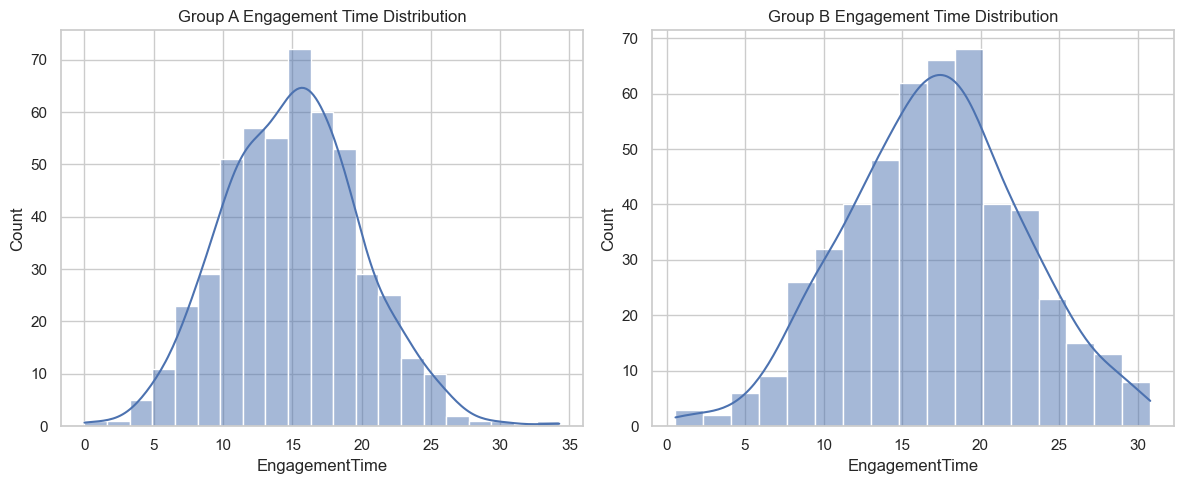

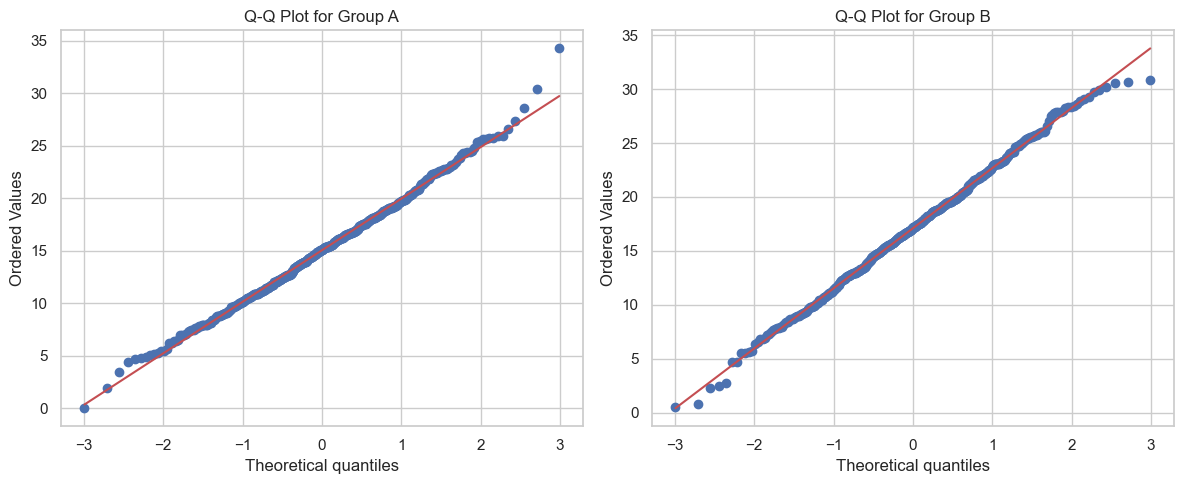

In [25]:
# Visual Check (Histograms and Q-Q Plots)
print("\nVisualizing Distributions:")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df[df['Group'] == 'A']['EngagementTime'], kde=True)
plt.title('Group A Engagement Time Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df[df['Group'] == 'B']['EngagementTime'], kde=True)
plt.title('Group B Engagement Time Distribution')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(df[df['Group'] == 'A']['EngagementTime'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Group A')

plt.subplot(1, 2, 2)
stats.probplot(df[df['Group'] == 'B']['EngagementTime'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Group B')
plt.tight_layout()
plt.show()

### **5.2. Homogeneity of Variances Check (Levene's Test)**

In [26]:
# H₀: The variances of the two groups are equal.
# H₁: The variances of the two groups are not equal.


print("\n--- Homogeneity of Variances Check (Levene's Test) ---")
levene_test = stats.levene(df[df['Group'] == 'A']['EngagementTime'],
                           df[df['Group'] == 'B']['EngagementTime'])

print(f"Levene's Test: Statistics={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")


--- Homogeneity of Variances Check (Levene's Test) ---
Levene's Test: Statistics=6.9536, p-value=0.0085


In [27]:
# Interpretation of Levene's Test
if levene_test.pvalue > alpha:
    print("Interpretation: Variances are assumed equal (fail to reject H₀).")
    equal_variance_assumed = True
else:
    print("Interpretation: Variances are not equal (reject H₀).")
    equal_variance_assumed = False

Interpretation: Variances are not equal (reject H₀).


## **6. Performing Statistical Test**

Based on the assumption checks:
- If Normality and Homogeneity of Variances hold: Use standard Independent Samples t-test.
- If Normality holds but Homogeneity of Variances does not: Use Welch's t-test (Independent Samples t-test with `equal_var=False`).
- If Normality does not hold: Use a non-parametric test like the Mann-Whitney U test.

In [33]:
print("\n--- Performing Statistical Test ---")

if normality_assumed:
    print("Proceeding with t-test (checking equal variance assumption).")
    # Perform Independent Samples t-test
    # `equal_var` is set based on Levene's test result
    t_stat, p_value_ttest = stats.ttest_ind(
        df[df['Group'] == 'A']['EngagementTime'],
        df[df['Group'] == 'B']['EngagementTime'],
        equal_var=equal_variance_assumed,
        alternative='two-sided' # Standard two-sided test
    )
    print(f"Test Used: {'Standard t-test' if equal_variance_assumed else "Welch's t-test"}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value (two-tailed): {p_value_ttest:.4f}")
    test_used = "t-test"
    p_value = p_value_ttest

else:
    print("Normality assumption failed. Proceeding with Mann-Whitney U test.")
    # Perform Mann-Whitney U test (non-parametric alternative)
    u_stat, p_value_mannwhitney = stats.mannwhitneyu(
        df[df['Group'] == 'A']['EngagementTime'],
        df[df['Group'] == 'B']['EngagementTime'],
        alternative='two-sided' # Use two-sided to match t-test approach initially
    )
    print(f"Test Used: Mann-Whitney U test")
    print(f"U-statistic: {u_stat:.4f}")
    print(f"P-value (two-tailed): {p_value_mannwhitney:.4f}")
    test_used = "Mann-Whitney U"
    p_value = p_value_mannwhitney


--- Performing Statistical Test ---
Proceeding with t-test (checking equal variance assumption).
Test Used: Welch's t-test
T-statistic: -6.2187
P-value (two-tailed): 0.0000


## **7. Interpretation of Results**

In [32]:
print("\n--- Interpretation ---")
print(f"Significance Level (α): {alpha}")
print(f"P-value from the test ({test_used}): {p_value:.4f}")


--- Interpretation ---
Significance Level (α): 0.05
P-value from the test (t-test): 0.0000


In [40]:
# Compare p-value to alpha
if p_value < alpha:
    print(f"\nConclusion: Reject the Null Hypothesis (H₀) as p-value is smaller than alpha = 0.05.")
    print("\nSo, there is a statistically significant difference in the mean engagement time between the old layout (Group A) and the new layout (Group B).")
    
    # Check the direction of the difference
    mean_val_A = df[df['Group'] == 'A']['EngagementTime'].mean()
    mean_val_B = df[df['Group'] == 'B']['EngagementTime'].mean()
    print(f"\nMean Engagement Time (Group A): {mean_val_A:.2f} minutes")
    print(f"Mean Engagement Time (Group B): {mean_val_B:.2f} minutes")
    if mean_val_B > mean_val_A:
        print("\nSpecifically, the new layout (Group B) shows a significantly higher average engagement time.")
    else:
        print("\nSpecifically, the old layout (Group A) shows a significantly higher average engagement time.") # Less likely given our generated data, but good to check

else:
    print(f"\nConclusion: Fail to Reject the Null Hypothesis (H₀).")
    print("So, there is not enough evidence to conclude a statistically significant difference in the mean engagement time between the old layout (Group A) and the new layout (Group B) at the {alpha*100}% significance level.")


Conclusion: Reject the Null Hypothesis (H₀) as p-value is smaller than alpha = 0.05.

So, there is a statistically significant difference in the mean engagement time between the old layout (Group A) and the new layout (Group B).

Mean Engagement Time (Group A): 15.04 minutes
Mean Engagement Time (Group B): 17.10 minutes

Specifically, the new layout (Group B) shows a significantly higher average engagement time.


## **8. Effect Size and Power Analysis**

In [37]:
# Effect size gives magnitude of the difference, power tells probability of detecting an effect if it exists.

if test_used == "t-test":
    # Calculate Cohen's d for effect size
    n1, n2 = sample_size_A, sample_size_B
    s1, s2 = np.std(engagement_A, ddof=1), np.std(engagement_B, ddof=1) # Sample std dev
    mean1, mean2 = np.mean(engagement_A), np.mean(engagement_B)

    # Pooled standard deviation (use if equal variances assumed)
    if equal_variance_assumed:
      s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
      cohen_d = (mean2 - mean1) / s_pooled
      print(f"\nCohen's d (assuming equal variance): {cohen_d:.4f}")
    else:
      # Use average std dev if variances unequal (approximation)
      s_avg = np.sqrt((s1**2 + s2**2) / 2)
      cohen_d = (mean2 - mean1) / s_avg
      print(f"\nCohen's d (not assuming equal variance): {cohen_d:.4f}")


    # Post-hoc Power Analysis
    # Calculate power given the observed effect size, sample size, and alpha
    power = smp.TTestIndPower().power(effect_size=cohen_d, nobs1=n1, alpha=alpha, ratio=n2/n1, alternative='two-sided')
    print(f"Achieved Power: {power:.4f}")
    if power < 0.8:
        print("Note: The achieved power is less than the common target of 0.8, suggesting a higher risk of Type II error (failing to detect a true difference). Consider increasing sample size in future tests.")
    else:
        print("Note: The achieved power is adequate (>= 0.8).")


Cohen's d (not assuming equal variance): 0.3933
Achieved Power: 1.0000
Note: The achieved power is adequate (>= 0.8).
